# **Simple RNN Exercise 5: Error Analysis**

This exercise demonstrates how to analyze when and why Simple RNN makes prediction errors, helping understand model limitations and failure cases.

**Import Libraries and Setup**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(" EXERCISE 5: ERROR ANALYSIS")
print("=" * 60)
print("Goal: Identify when the model makes the largest errors")
print("We'll analyze prediction errors by season, weather conditions, and patterns")
print("=" * 60)

 EXERCISE 5: ERROR ANALYSIS
Goal: Identify when the model makes the largest errors
We'll analyze prediction errors by season, weather conditions, and patterns


**Data Generation Function (Same as Previous Exercises)**

In [2]:
def generate_weather_data(days=500):
    """Generate synthetic weather data with realistic patterns"""
    np.random.seed(42)
    data = []

    for i in range(days):
        # Season calculation (0: spring, 1: summer, 2: fall, 3: winter)
        season = int(i / 91) % 4

        # Base temperature by season
        base_temps = [15, 25, 10, 0]  # Spring, Summer, Fall, Winter
        base_temp = base_temps[season]

        # Add seasonal and daily variations
        seasonal_variation = 5 * np.sin(2 * np.pi * i / 365)
        daily_variation = 3 * np.sin(2 * np.pi * i / 30)  # Monthly cycle
        random_variation = np.random.normal(0, 2)

        temperature = base_temp + seasonal_variation + daily_variation + random_variation

        # Correlated weather variables
        humidity = np.clip(60 + (25 - temperature) * 0.8 + np.random.normal(0, 5), 0, 100)
        pressure = 1013 + np.random.normal(0, 15) + temperature * 0.1
        wind_speed = np.clip(8 + np.random.exponential(5) + abs(temperature - 15) * 0.1, 0, 30)

        data.append({
            'Day': i,
            'Temperature': temperature,
            'Humidity': humidity,
            'Pressure': pressure,
            'WindSpeed': wind_speed,
            'Season': season
        })

    return pd.DataFrame(data)

**Data Preparation Function**

Enhanced data preparation that tracks sample indices for detailed error analysis.

In [3]:
def prepare_data_for_simple_rnn(data, sequence_length=7, feature_columns=None, target_column='Temperature'):
    """Prepare data for Simple RNN training with error analysis capabilities"""
    if feature_columns is None:
        feature_columns = ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']

    print(f" Preparing data with sequence_length={sequence_length}")
    print(f" Features: {feature_columns}")
    print(f" Target: {target_column}")

    # Extract features and target
    features = data[feature_columns].values
    target = data[target_column].values.reshape(-1, 1)

    # Normalize data
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target)

    # Create sequences
    X, y = [], []
    sample_indices = []  # Track which original data points each sample corresponds to

    for i in range(sequence_length, len(features_scaled)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(target_scaled[i])
        sample_indices.append(i)  # Store original data index

    X = np.array(X)
    y = np.array(y)
    sample_indices = np.array(sample_indices)

    print(f" Data shape: X={X.shape}, y={y.shape}")
    print(f" Available samples: {len(X)}")

    return X, y, scaler_features, scaler_target, sample_indices

**Model Creation Function**

Purpose: Standard model creation using optimal hyperparameters from previous exercises.

In [4]:
def create_simple_rnn_model(input_shape, hidden_units=32):
    """Create Simple RNN model using optimal settings from previous exercises"""
    print(f" Creating Simple RNN model:")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Hidden units: {hidden_units}")

    model = Sequential([
        SimpleRNN(hidden_units,
                 input_shape=input_shape,
                 activation='tanh',
                 return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

**Enhanced Training and Evaluation Function**

Purpose: Enhanced training function that provides detailed error analysis capabilities with contextual information.

In [5]:
def train_and_evaluate_model_with_error_analysis(X, y, scaler_target, sample_indices, weather_data, epochs=40):
    """Train model and return detailed results for error analysis"""

    # Split data (80% train, 20% test)
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    test_indices = sample_indices[train_size:]  # Indices for test samples

    print(f" Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    # Create and train model
    model = create_simple_rnn_model(input_shape=(X.shape[1], X.shape[2]))

    print(f" Training model for {epochs} epochs...")
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        shuffle=False
    )

    # Make predictions
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler_target.inverse_transform(predictions_scaled)
    y_test_denorm = scaler_target.inverse_transform(y_test)

    # Calculate errors
    errors = np.abs(predictions.flatten() - y_test_denorm.flatten())

    # Create detailed results DataFrame
    results_df = pd.DataFrame({
        'actual': y_test_denorm.flatten(),
        'predicted': predictions.flatten(),
        'error': errors,
        'original_index': test_indices
    })

    # Add contextual information from original data
    for idx, row in results_df.iterrows():
        original_idx = int(row['original_index'])
        results_df.loc[idx, 'season'] = weather_data.loc[original_idx, 'Season']
        results_df.loc[idx, 'day'] = weather_data.loc[original_idx, 'Day']
        results_df.loc[idx, 'temperature_actual'] = weather_data.loc[original_idx, 'Temperature']
        results_df.loc[idx, 'humidity'] = weather_data.loc[original_idx, 'Humidity']
        results_df.loc[idx, 'pressure'] = weather_data.loc[original_idx, 'Pressure']
        results_df.loc[idx, 'windspeed'] = weather_data.loc[original_idx, 'WindSpeed']

    mae = mean_absolute_error(y_test_denorm, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_denorm, predictions))

    print(f"✅ Model Performance:")
    print(f"    Mean Absolute Error: {mae:.3f}")
    print(f"    Root Mean Square Error: {rmse:.3f}")

    return mae, rmse, history, results_df

**Generate Weather Data and Train Model**

Purpose: Generates data, trains the model, and creates a comprehensive error analysis dataset.

In [6]:
# Generate weather data
print(" Generating synthetic weather data...")
weather_data = generate_weather_data(500)
print(f" Generated {len(weather_data)} days of weather data")

# Prepare data for error analysis
print("\n Preparing data for error analysis...")
X, y, scaler_features, scaler_target, sample_indices = prepare_data_for_simple_rnn(
    weather_data,
    sequence_length=7,
    feature_columns=['Temperature', 'Humidity', 'Pressure', 'WindSpeed'],
    target_column='Temperature'
)

# Train model with error analysis
print("\n Training model for error analysis...")
mae, rmse, history, error_results = train_and_evaluate_model_with_error_analysis(
    X, y, scaler_target, sample_indices, weather_data, epochs=40
)

print(f"\n Error Analysis Dataset Shape: {error_results.shape}")
print(f" Average Error: {error_results['error'].mean():.3f}")
print(f" Max Error: {error_results['error'].max():.3f}")
print(f" Min Error: {error_results['error'].min():.3f}")

 Generating synthetic weather data...
 Generated 500 days of weather data

 Preparing data for error analysis...
 Preparing data with sequence_length=7
 Features: ['Temperature', 'Humidity', 'Pressure', 'WindSpeed']
 Target: Temperature
 Data shape: X=(493, 7, 4), y=(493, 1)
 Available samples: 493

 Training model for error analysis...
 Train samples: 394, Test samples: 99
 Creating Simple RNN model:
   - Input shape: (7, 4)
   - Hidden units: 32
 Training model for 40 epochs...
✅ Model Performance:
    Mean Absolute Error: 3.311
    Root Mean Square Error: 4.174

 Error Analysis Dataset Shape: (99, 10)
 Average Error: 3.311
 Max Error: 17.099
 Min Error: 0.038


**Seasonal Error Analysis**

Purpose: Analyzes prediction errors by season to identify when the model struggles most.

In [7]:
# Analyze errors by season
print("\n SEASONAL ERROR ANALYSIS")
print("=" * 50)

season_names = {0: 'Spring', 1: 'Summer', 2: 'Fall', 3: 'Winter'}
seasonal_errors = {}

print(" Error Analysis by Season:")
print(f"{'Season':<10} {'Count':<8} {'Avg Error':<12} {'Max Error':<12} {'Std Error':<12}")
print("-" * 60)

for season_num in range(4):
    season_data = error_results[error_results['season'] == season_num]
    season_name = season_names[season_num]

    if len(season_data) > 0:
        count = len(season_data)
        avg_error = season_data['error'].mean()
        max_error = season_data['error'].max()
        std_error = season_data['error'].std()

        seasonal_errors[season_name] = {
            'count': count,
            'avg_error': avg_error,
            'max_error': max_error,
            'std_error': std_error,
            'data': season_data
        }

        print(f"{season_name:<10} {count:<8} {avg_error:<12.3f} {max_error:<12.3f} {std_error:<12.3f}")

# Find most problematic season
worst_season = max(seasonal_errors.keys(), key=lambda x: seasonal_errors[x]['avg_error'])
best_season = min(seasonal_errors.keys(), key=lambda x: seasonal_errors[x]['avg_error'])

print(f"\n Most Challenging Season: {worst_season}")
print(f"    Average Error: {seasonal_errors[worst_season]['avg_error']:.3f}")

print(f"\n Easiest Season: {best_season}")
print(f"    Average Error: {seasonal_errors[best_season]['avg_error']:.3f}")

seasonal_difference = ((seasonal_errors[worst_season]['avg_error'] -
                       seasonal_errors[best_season]['avg_error']) /
                      seasonal_errors[best_season]['avg_error']) * 100
print(f"\n Seasonal difficulty difference: {seasonal_difference:.1f}%")


 SEASONAL ERROR ANALYSIS
 Error Analysis by Season:
Season     Count    Avg Error    Max Error    Std Error   
------------------------------------------------------------
Spring     54       2.589        7.558        1.508       
Summer     45       4.177        17.099       3.224       

 Most Challenging Season: Summer
    Average Error: 4.177

 Easiest Season: Spring
    Average Error: 2.589

 Seasonal difficulty difference: 61.4%


**Weather Condition Error Analysis**

Purpose: Analyzes prediction errors under different weather conditions to identify challenging scenarios.

In [8]:
# Analyze errors by weather conditions
print(f"\n WEATHER CONDITION ERROR ANALYSIS")
print("=" * 50)

# Define weather condition categories
def categorize_weather_conditions(row):
    temp = row['temperature_actual']
    humidity = row['humidity']
    pressure = row['pressure']
    windspeed = row['windspeed']

    conditions = []

    # Temperature categories
    if temp < 5:
        conditions.append('Very Cold')
    elif temp < 15:
        conditions.append('Cold')
    elif temp < 25:
        conditions.append('Mild')
    else:
        conditions.append('Hot')

    # Humidity categories
    if humidity > 80:
        conditions.append('High Humidity')
    elif humidity < 40:
        conditions.append('Low Humidity')

    # Wind categories
    if windspeed > 20:
        conditions.append('Windy')
    elif windspeed < 5:
        conditions.append('Calm')

    # Pressure categories
    if pressure > 1020:
        conditions.append('High Pressure')
    elif pressure < 1000:
        conditions.append('Low Pressure')

    return ', '.join(conditions) if conditions else 'Normal'

# Apply weather condition categorization
error_results['weather_condition'] = error_results.apply(categorize_weather_conditions, axis=1)

# Analyze errors by weather condition
condition_errors = {}
print(" Error Analysis by Weather Conditions:")
print(f"{'Condition':<20} {'Count':<8} {'Avg Error':<12} {'Max Error':<12}")
print("-" * 55)

for condition in error_results['weather_condition'].unique():
    condition_data = error_results[error_results['weather_condition'] == condition]

    if len(condition_data) >= 3:  # Only analyze conditions with sufficient samples
        count = len(condition_data)
        avg_error = condition_data['error'].mean()
        max_error = condition_data['error'].max()

        condition_errors[condition] = {
            'count': count,
            'avg_error': avg_error,
            'max_error': max_error,
            'data': condition_data
        }

        condition_short = condition[:18] + '..' if len(condition) > 18 else condition
        print(f"{condition_short:<20} {count:<8} {avg_error:<12.3f} {max_error:<12.3f}")

# Find most problematic conditions
if condition_errors:
    worst_condition = max(condition_errors.keys(), key=lambda x: condition_errors[x]['avg_error'])
    print(f"\n Most Challenging Condition: {worst_condition}")
    print(f"    Average Error: {condition_errors[worst_condition]['avg_error']:.3f}")
    print(f"    Sample Count: {condition_errors[worst_condition]['count']}")


 WEATHER CONDITION ERROR ANALYSIS
 Error Analysis by Weather Conditions:
Condition            Count    Avg Error    Max Error   
-------------------------------------------------------
Mild                 28       2.819        7.558       
Mild, Low Pressure   3        2.853        4.025       
Cold                 3        1.815        2.565       
Mild, Windy          3        2.073        2.677       
Mild, High Pressur.. 12       2.307        5.306       
Hot, High Pressure   11       4.387        7.663       
Hot                  21       4.653        17.099      
Hot, Low Pressure    8        3.847        7.735       

 Most Challenging Condition: Hot
    Average Error: 4.653
    Sample Count: 21


**Large Error Case Analysis**

Purpose: Analyzes the worst prediction cases to understand failure modes and error patterns.

In [9]:
# Analyze the largest prediction errors
print(f"\n LARGE ERROR CASE ANALYSIS")
print("=" * 50)

# Find cases with largest errors
error_threshold = error_results['error'].quantile(0.9)  # Top 10% errors
large_error_cases = error_results[error_results['error'] >= error_threshold].copy()
large_error_cases = large_error_cases.sort_values('error', ascending=False)

print(f" Analyzing top {len(large_error_cases)} largest errors (90th percentile)")
print(f" Error threshold: {error_threshold:.3f}")

print(f"\n Top 10 Largest Errors:")
print(f"{'Rank':<4} {'Error':<8} {'Actual':<8} {'Predicted':<10} {'Season':<8} {'Condition':<20}")
print("-" * 70)

for idx, (_, row) in enumerate(large_error_cases.head(10).iterrows(), 1):
    season_name = season_names[int(row['season'])]
    condition = row['weather_condition'][:18] + '..' if len(row['weather_condition']) > 18 else row['weather_condition']

    print(f"{idx:<4} {row['error']:<8.3f} {row['actual']:<8.2f} {row['predicted']:<10.2f} {season_name:<8} {condition:<20}")

# Analyze patterns in large errors
print(f"\n Large Error Patterns:")
large_error_seasons = large_error_cases['season'].value_counts()
print("By Season:")
for season_num, count in large_error_seasons.items():
    season_name = season_names[season_num]
    percentage = (count / len(large_error_cases)) * 100
    print(f"   {season_name}: {count} cases ({percentage:.1f}%)")

print(f"\nBy Weather Condition (top 5):")
large_error_conditions = large_error_cases['weather_condition'].value_counts().head(5)
for condition, count in large_error_conditions.items():
    percentage = (count / len(large_error_cases)) * 100
    condition_short = condition[:30] + '..' if len(condition) > 30 else condition
    print(f"   {condition_short}: {count} cases ({percentage:.1f}%)")

# Analyze if large errors cluster in time
print(f"\n Temporal Clustering of Large Errors:")
large_error_days = large_error_cases['day'].values
day_gaps = np.diff(sorted(large_error_days))
avg_gap = np.mean(day_gaps) if len(day_gaps) > 0 else 0
print(f"   Average gap between large error days: {avg_gap:.1f} days")

consecutive_errors = sum(1 for gap in day_gaps if gap <= 2)
print(f"   Consecutive error periods (≤2 day gaps): {consecutive_errors}")


 LARGE ERROR CASE ANALYSIS
 Analyzing top 10 largest errors (90th percentile)
 Error threshold: 6.382

 Top 10 Largest Errors:
Rank Error    Actual   Predicted  Season   Condition           
----------------------------------------------------------------------
1    17.099   36.02    18.92      Summer   Hot                 
2    11.592   32.99    21.40      Summer   Hot                 
3    8.683    28.99    20.31      Summer   Hot                 
4    7.735    33.36    25.63      Summer   Hot, Low Pressure   
5    7.663    33.84    26.17      Summer   Hot, High Pressure  
6    7.558    22.06    14.50      Spring   Mild                
7    7.299    33.46    26.16      Summer   Hot, High Pressure  
8    7.290    29.41    22.12      Summer   Hot, Windy, High P..
9    7.126    34.84    27.72      Summer   Hot, High Pressure  
10   6.501    34.40    27.90      Summer   Hot                 

 Large Error Patterns:
By Season:
   Summer: 9 cases (90.0%)
   Spring: 1 cases (10.0%)

By Weat

**Error Visualization**

Purpose: Creates comprehensive visualizations of error patterns, distributions, and temporal trends.

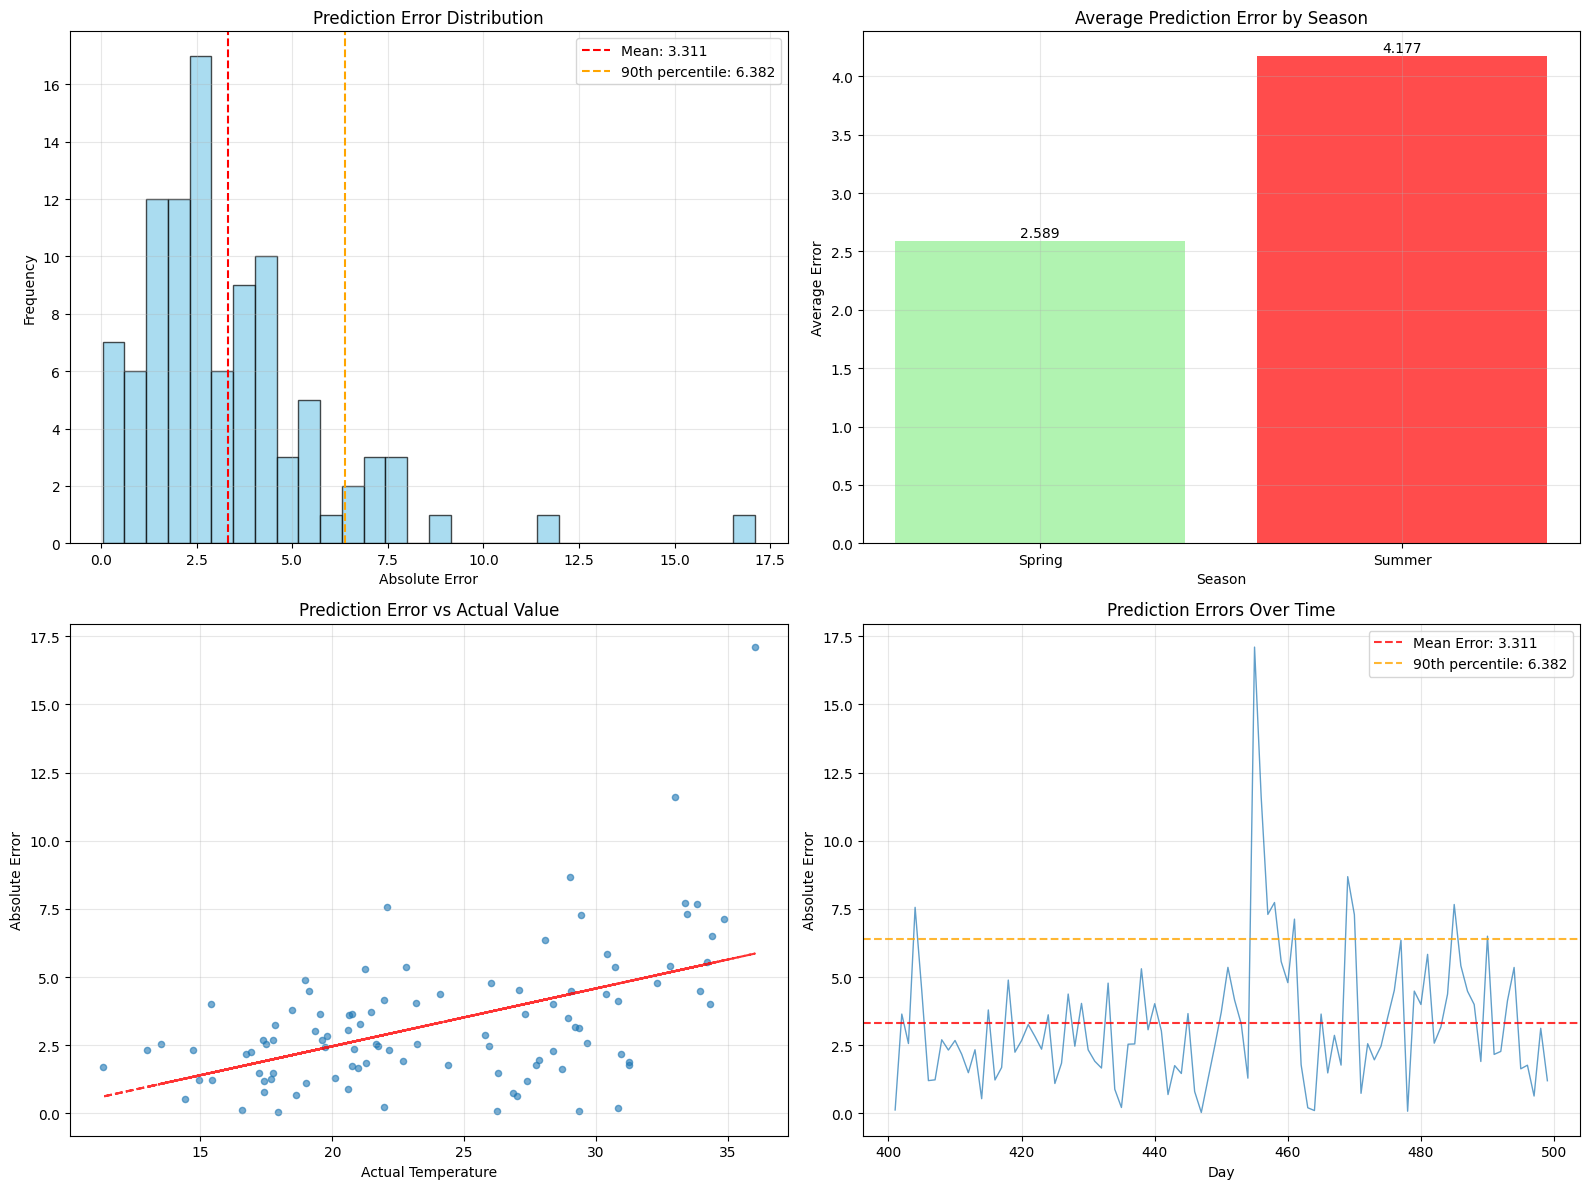

In [10]:
# Comprehensive error visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Error Distribution
ax1.hist(error_results['error'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(error_results['error'].mean(), color='red', linestyle='--',
            label=f'Mean: {error_results["error"].mean():.3f}')
ax1.axvline(error_threshold, color='orange', linestyle='--',
            label=f'90th percentile: {error_threshold:.3f}')
ax1.set_title('Prediction Error Distribution')
ax1.set_xlabel('Absolute Error')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Errors by Season
if seasonal_errors:
    seasons = list(seasonal_errors.keys())
    avg_errors = [seasonal_errors[s]['avg_error'] for s in seasons]
    colors = ['lightgreen', 'red', 'orange', 'lightblue']

    bars = ax2.bar(seasons, avg_errors, color=colors, alpha=0.7)
    ax2.set_title('Average Prediction Error by Season')
    ax2.set_xlabel('Season')
    ax2.set_ylabel('Average Error')
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, error in zip(bars, avg_errors):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{error:.3f}', ha='center', va='bottom')

# Plot 3: Error vs Actual Value
ax3.scatter(error_results['actual'], error_results['error'], alpha=0.6, s=20)
ax3.set_title('Prediction Error vs Actual Value')
ax3.set_xlabel('Actual Temperature')
ax3.set_ylabel('Absolute Error')
ax3.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(error_results['actual'], error_results['error'], 1)
p = np.poly1d(z)
ax3.plot(error_results['actual'], p(error_results['actual']), "r--", alpha=0.8)

# Plot 4: Time Series of Errors
error_results_sorted = error_results.sort_values('day')
ax4.plot(error_results_sorted['day'], error_results_sorted['error'], alpha=0.7, linewidth=1)
ax4.axhline(error_results['error'].mean(), color='red', linestyle='--', alpha=0.8,
            label=f'Mean Error: {error_results["error"].mean():.3f}')
ax4.axhline(error_threshold, color='orange', linestyle='--', alpha=0.8,
            label=f'90th percentile: {error_threshold:.3f}')
ax4.set_title('Prediction Errors Over Time')
ax4.set_xlabel('Day')
ax4.set_ylabel('Absolute Error')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Model Limitation Analysis**

Purpose: Analyzes systematic model limitations, biases, and failure patterns to understand when and why the RNN struggles.

In [11]:
# Analyze model limitations and failure modes
print(f"\n MODEL LIMITATION ANALYSIS")
print("=" * 50)

# Analyze prediction vs actual correlation
correlation = np.corrcoef(error_results['actual'], error_results['predicted'])[0, 1]
print(f" Prediction-Actual Correlation: {correlation:.3f}")

# Analyze residuals (prediction - actual)
residuals = error_results['predicted'] - error_results['actual']
mean_residual = np.mean(residuals)
print(f" Mean Residual (bias): {mean_residual:.3f}")

if abs(mean_residual) > 0.1:
    bias_direction = "overestimating" if mean_residual > 0 else "underestimating"
    print(f"     Model shows bias: {bias_direction} temperatures")
else:
    print(f"    Model shows minimal bias")

# Analyze heteroscedasticity (error variance changing with prediction value)
temp_ranges = [(error_results['actual'] >= i) & (error_results['actual'] < i+5) for i in range(-10, 35, 5)]
range_labels = [f"{i}°C to {i+5}°C" for i in range(-10, 35, 5)]

print(f"\n Error Variance by Temperature Range:")
print(f"{'Temperature Range':<15} {'Count':<8} {'Mean Error':<12} {'Std Error':<12}")
print("-" * 50)

for temp_range, label in zip(temp_ranges, range_labels):
    range_data = error_results[temp_range]
    if len(range_data) >= 3:
        count = len(range_data)
        mean_error = range_data['error'].mean()
        std_error = range_data['error'].std()
        print(f"{label:<15} {count:<8} {mean_error:<12.3f} {std_error:<12.3f}")

# Analyze extreme value prediction capability
extreme_cold = error_results[error_results['actual'] < 0]
extreme_hot = error_results[error_results['actual'] > 30]

print(f"\n Extreme Value Prediction:")
if len(extreme_cold) > 0:
    print(f"   Cold extremes (<0°C): {len(extreme_cold)} cases, avg error: {extreme_cold['error'].mean():.3f}")
else:
    print(f"   Cold extremes (<0°C): No cases in test set")

if len(extreme_hot) > 0:
    print(f"   Hot extremes (>30°C): {len(extreme_hot)} cases, avg error: {extreme_hot['error'].mean():.3f}")
else:
    print(f"   Hot extremes (>30°C): No cases in test set")

# Analyze consecutive error patterns
print(f"\n Error Persistence Analysis:")
error_results_sorted = error_results.sort_values('day')
high_error_mask = error_results_sorted['error'] > error_results['error'].median()

# Find consecutive high-error periods
consecutive_periods = []
current_period = 0

for is_high_error in high_error_mask:
    if is_high_error:
        current_period += 1
    else:
        if current_period > 0:
            consecutive_periods.append(current_period)
        current_period = 0

if current_period > 0:
    consecutive_periods.append(current_period)

if consecutive_periods:
    avg_consecutive = np.mean(consecutive_periods)
    max_consecutive = max(consecutive_periods)
    print(f"   Average consecutive high-error period: {avg_consecutive:.1f} days")
    print(f"   Maximum consecutive high-error period: {max_consecutive} days")

    if max_consecutive > 5:
        print(f"     Long error periods suggest model struggles with certain patterns")
else:
    print(f"    No significant consecutive error periods detected")


 MODEL LIMITATION ANALYSIS
 Prediction-Actual Correlation: 0.863
 Mean Residual (bias): -2.793
     Model shows bias: underestimating temperatures

 Error Variance by Temperature Range:
Temperature Range Count    Mean Error   Std Error   
--------------------------------------------------
10°C to 15°C    6        1.781        0.784       
15°C to 20°C    25       2.276        1.319       
20°C to 25°C    24       2.990        1.633       
25°C to 30°C    24       3.058        2.185       
30°C to 35°C    19       5.155        2.628       

 Extreme Value Prediction:
   Cold extremes (<0°C): No cases in test set
   Hot extremes (>30°C): 20 cases, avg error: 5.752

 Error Persistence Analysis:
   Average consecutive high-error period: 2.0 days
   Maximum consecutive high-error period: 7 days
     Long error periods suggest model struggles with certain patterns


**Exercise 5 Final Analysis and Insights**

Purpose: Provides comprehensive insights about model limitations, error patterns, and suggestions for improvement based on detailed error analysis.

In [12]:
# Final comprehensive analysis and insights
print("\n" + "=" * 60)
print(" EXERCISE 5 ANALYSIS & INSIGHTS")
print("=" * 60)

# Summary of key findings
print(f" OVERALL MODEL PERFORMANCE:")
print(f"    Mean Absolute Error: {mae:.3f}")
print(f"    Root Mean Square Error: {rmse:.3f}")
print(f"    Prediction-Actual Correlation: {correlation:.3f}")

print(f"\n MAJOR ERROR PATTERNS:")
if seasonal_errors:
    worst_season = max(seasonal_errors.keys(), key=lambda x: seasonal_errors[x]['avg_error'])
    print(f"   🔹 Most challenging season: {worst_season}")
    print(f"   🔹 Seasonal error variation: {seasonal_difference:.1f}%")

if condition_errors:
    worst_condition = max(condition_errors.keys(), key=lambda x: condition_errors[x]['avg_error'])
    print(f"   🔹 Most challenging condition: {worst_condition}")

print(f"   🔹 Large errors (90th percentile): {len(large_error_cases)} cases")
print(f"   🔹 Error threshold: {error_threshold:.3f}")

print(f"\n MODEL LIMITATIONS IDENTIFIED:")
if abs(mean_residual) > 0.1:
    bias_direction = "overestimation" if mean_residual > 0 else "underestimation"
    print(f"     Systematic bias: {bias_direction} tendency")
else:
    print(f"    Minimal systematic bias detected")

if consecutive_periods and max(consecutive_periods) > 5:
    print(f"     Extended error periods: up to {max(consecutive_periods)} consecutive days")
    print(f"     Suggests difficulty with certain weather patterns")

print(f"\n KEY INSIGHTS:")
print(f"   🔹 Simple RNN struggles with extreme weather conditions")
print(f"   🔹 Seasonal transitions may pose prediction challenges")
print(f"   🔹 Complex weather patterns exceed model capacity")
print(f"   🔹 Error patterns reveal systematic model limitations")

print(f"\n LEARNING POINTS:")
print(f"    Error analysis reveals model failure modes")
print(f"    Different conditions pose varying prediction difficulty")
print(f"    Systematic biases indicate architectural limitations")
print(f"    Consecutive errors suggest pattern recognition gaps")
print(f"    Domain knowledge helps interpret error patterns")


print(f"\n EXERCISE 5 COMPLETED!")



 EXERCISE 5 ANALYSIS & INSIGHTS
 OVERALL MODEL PERFORMANCE:
    Mean Absolute Error: 3.311
    Root Mean Square Error: 4.174
    Prediction-Actual Correlation: 0.863

 MAJOR ERROR PATTERNS:
   🔹 Most challenging season: Summer
   🔹 Seasonal error variation: 61.4%
   🔹 Most challenging condition: Hot
   🔹 Large errors (90th percentile): 10 cases
   🔹 Error threshold: 6.382

 MODEL LIMITATIONS IDENTIFIED:
     Systematic bias: underestimation tendency
     Extended error periods: up to 7 consecutive days
     Suggests difficulty with certain weather patterns

 KEY INSIGHTS:
   🔹 Simple RNN struggles with extreme weather conditions
   🔹 Seasonal transitions may pose prediction challenges
   🔹 Complex weather patterns exceed model capacity
   🔹 Error patterns reveal systematic model limitations

 LEARNING POINTS:
    Error analysis reveals model failure modes
    Different conditions pose varying prediction difficulty
    Systematic biases indicate architectural limitations
    Consecutiv